<a href="https://colab.research.google.com/github/Walt9819/factores-impacto-desempleo-mexico/blob/main/Machine_Learning/ML_restaurantes_2clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recuperación económica post-COVID: Localización óptima de restaurantes en México**

La pandemia de COVID-19 afectó a varios sectores de la economía, entre los cuales se encuentra el sector restaurantero.

Como respuesta al reto que se avecina para este sector con la llamada ***nueva normalidad*** en progreso, este análisis exhaustivo de los datos socioeconómicos y sociodemográficos representa una gran oportunidad para encontrar los municipios donde sería viable aperturar un nuevo restaurante haciendo uso de datos económicos, geográficos, delictivos, salubridad, y percepción en redes sociales. 

Adicional, ofrece a los usuarios una visualización predictiva del escenario sobre el cual accionar, y permite estudiar y comprender los nuevos hábitos de consumo y patrones de comportamiento en una ubicación en particular a través de modelos de machine learning.

---

Las variables utilizadas, por cada fuente de información, son las siguientes:

*Identificadores:*

- ***imun***:	Identificador por municipio y entidad
- ***ent***:	Clave de la entidad
- ***nom_ent***: Nombre de la entidad	
- ***mun***: Clave del municipio
- ***nom_mun***: Nombre del municipio
- ***CVEGEO***: Clave geográfica

*Censo Nacional de Población y Vivienda:*

- ***pobtot***: Población total

*Encuesta Nacional de Ocupación y Empleo:*

- ***ing_lab***: Ingreso laboral promedio
- ***pea***: Población económicamente activa
- ***ocupada***:	Población ocupada en alguna actividad económica

*Directorio Estadístico Nacional de Unidades Económicas:*

- ***tra_omun***: Población que trabaja en la misma entidad pero en un municipio distinto al de residencia
- ***tot_est***: Total de establecimientos
- ***est_e_a***: Número de establecimientos esenciales
- ***est_n_e_a***: Número de establecimientos no esenciales
- ***tot_p_o***: Personas ocupadas en los establecimientos
- ***po_e_a***: Personas ocupadas en los establecimientos esenciales
- ***po_n_e_a***: Personas ocupadas en los establecimientos no esenciales
- ***comida_carta_corrida***:	Número de restaurantes con servicio de preparación de alimentos a la carta o de comida corrida
- ***antojitos***: Número de restaurantes con servicio de preparación de antojitos
- ***pescados_mariscos***:	Número de restaurantes con servicio de preparación de pescados y mariscos
- ***comida_rapida***: Número de restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar
- ***tacos_tortas***: Número de restaurantes con servicio de preparación de tacos y tortas
- ***autoservicio***: Número de restaurantes de autoservicio
- ***otro_tipo_alimentos***:	Número de restaurantes que preparan otro tipo de alimentos para llevar

*Datos Abiertos de Incidencia Delictiva*

- ***amenazas***: Número de reportes por amenazas
- ***danio_propiedad***:	Número de reportes por daño a la propiedad
- ***extorsion***: Número de reportes por extorsión
- ***robo_negocio***: Número de reportes por robo a negocios

## **Instalación e importación de módulos**

In [1]:
!pip install geopandas
!pip install pandas_bokeh

     |████████████████████████████████| 1.0MB 3.9MB/s 
     |████████████████████████████████| 15.4MB 246kB/s 
     |████████████████████████████████| 6.6MB 34.9MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import geopandas

import locale
from datetime import datetime
import plotly.express as px
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import dateutil

import pandas_bokeh
pandas_bokeh.output_notebook()
from tqdm import tqdm

## **Lectura de datasets**

El dataset consta de 2478 registros con 27 características. Cada registro representa la información sobre delicuencia, economía, demografía y conversación en redes sociales de todos los municipios a nivel nacional.

In [3]:
dataframe = pd.read_csv('https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Machine_Learning/data/data_merge_cluster.csv')
dataframe

,imun,ent,nom_ent,mun,nom_mun,pobtot,ing_lab,pea,ocupada,tra_omun,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,CVEGEO,amenazas,danio_propiedad,extorsion,robo_negocio
0,1001,1,Aguascalientes,1,Aguascalientes,877190,7676.46,382550,367528,9344,46426,23283,23142,334896,153478,181418,402,2092,192,506,1046,96,338,1001,3010,3370,88,1669
1,1002,1,Aguascalientes,2,Asientos,46464,5863.52,13914,13108,3585,989,549,440,5165,2023,3142,6,44,3,11,37,0,5,1002,96,116,1,45
2,1003,1,Aguascalientes,3,Calvillo,56048,5784.97,20099,19352,298,3280,1750,1529,14944,7370,7573,14,122,4,26,58,2,4,1003,60,139,3,54
3,1004,1,Aguascalientes,4,Cosío,15577,6096.05,4869,4627,1579,1000,591,408,4538,3172,1366,0,27,3,2,10,0,2,1004,17,35,4,22
4,1005,1,Aguascalientes,5,Jesús María,120405,6262.18,51020,49795,19699,6377,3402,2975,63320,22688,40631,28,207,24,57,154,3,28,1005,270,404,7,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,32054,32,Zacatecas,54,Villa Hidalgo,19155,1877.31,4538,4324,387,423,235,188,1176,690,486,0,17,2,9,10,0,0,32054,1,5,3,0
2459,32055,32,Zacatecas,55,Villanueva,30240,0.00,9018,8176,933,3532,2063,1468,8319,4943,3376,10,69,9,22,48,2,3,32055,35,57,7,3
2460,32056,32,Zacatecas,56,Zacatecas,146147,7421.03,60889,58330,4770,9716,5047,4669,82912,41650,41262,134,305,41,101,222,32,44,32056,297,512,98,62
2461,32057,32,Zacatecas,57,Trancoso,19413,6537.04,6039,5703,2474,665,408,257,1928,1011,917,3,30,1,11,10,0,0,32057,33,25,11,2


El dataset de conversación en redes sociales cuenta únicamente con la información de Twitter. Con ayuda de la API se extraen los tweets publicados que contengan palabras asociadas a comida para llevar, restaurantes y comida rápida. Al análisis, se incorporaron el número de tweets, retweets y favoritos por municipio. 

In [4]:
data_tweets = pd.read_csv('https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Machine_Learning/data/data_tweets.csv')
data_tweets.head()

,Unnamed: 0,full_name,city_full_name,state_full_name,followers_count,friends_count,favourites_count,retweet_count,favorite_count,tweet_count
0,1,"Acapulco de Juárez, Guerrero",Acapulco de Juárez,Guerrero,4778.235294,4924.627451,4791.392157,0.647059,0.392157,51
1,2,"Actopan, Hidalgo",Actopan,Hidalgo,1684.000000,168.000000,2468.000000,1.000000,2.000000,1
2,4,"Aguascalientes, México",Aguascalientes,México,2.000000,10.000000,0.000000,0.000000,0.000000,1
3,5,"Ahome, Sinaloa",Ahome,Sinaloa,536.500000,742.000000,11642.666667,0.333333,0.666667,6
4,6,"Aldama, Chihuahua",Aldama,Chihuahua,4417.000000,4998.000000,202283.000000,0.000000,1.000000,1


In [5]:
data_tweets = data_tweets[['city_full_name',
       'followers_count', 'friends_count', 'favourites_count', 'retweet_count',
       'favorite_count', 'tweet_count']]

In [6]:
data_tweets.columns = ['nom_mun',
       'followers_count', 'friends_count', 'favourites_count', 'retweet_count',
       'favorite_count', 'tweet_count']

La variable `dataframe` almacena el merge realizado a los datos socioeconomicos y sociodemográficos con los datos de Twitter. 

In [7]:
dataframe = dataframe.merge(data_tweets, on='nom_mun', how='left')
dataframe = dataframe.fillna(0)

Para fines análiticos y de estadística descriptiva, se eliminan los atributos con información alfanúmerica como las claves de los municipios y entidades, así como sus nombres.

In [8]:
df = dataframe.drop(['imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO','tra_omun'], axis=1)

In [9]:
df

,pobtot,ing_lab,pea,ocupada,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,amenazas,danio_propiedad,extorsion,robo_negocio,followers_count,friends_count,favourites_count,retweet_count,favorite_count,tweet_count
0,877190,7676.46,382550,367528,46426,23283,23142,334896,153478,181418,402,2092,192,506,1046,96,338,3010,3370,88,1669,2.0,10.0,0.0,0.0,0.0,1.0
1,46464,5863.52,13914,13108,989,549,440,5165,2023,3142,6,44,3,11,37,0,5,96,116,1,45,0.0,0.0,0.0,0.0,0.0,0.0
2,56048,5784.97,20099,19352,3280,1750,1529,14944,7370,7573,14,122,4,26,58,2,4,60,139,3,54,0.0,0.0,0.0,0.0,0.0,0.0
3,15577,6096.05,4869,4627,1000,591,408,4538,3172,1366,0,27,3,2,10,0,2,17,35,4,22,0.0,0.0,0.0,0.0,0.0,0.0
4,120405,6262.18,51020,49795,6377,3402,2975,63320,22688,40631,28,207,24,57,154,3,28,270,404,7,224,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,19155,1877.31,4538,4324,423,235,188,1176,690,486,0,17,2,9,10,0,0,1,5,3,0,0.0,0.0,0.0,0.0,0.0,0.0
2474,30240,0.00,9018,8176,3532,2063,1468,8319,4943,3376,10,69,9,22,48,2,3,35,57,7,3,0.0,0.0,0.0,0.0,0.0,0.0
2475,146147,7421.03,60889,58330,9716,5047,4669,82912,41650,41262,134,305,41,101,222,32,44,297,512,98,62,714.5,1101.0,11706.0,0.0,9.0,2.0
2476,19413,6537.04,6039,5703,665,408,257,1928,1011,917,3,30,1,11,10,0,0,33,25,11,2,0.0,0.0,0.0,0.0,0.0,0.0


## **Análisis exploratorio de datos**

Se usan los estimados de locación y variabilidad para describir el dataset. Al contar con un dataset limpio, se extrae información útil de él.

Los estimados de locación y variabilidad se pueden extraer cuando los atributos son numéricos (tanto discretos como continuos).

A continuación, se listan las actividades realizadas en esta etapa de procesamiento:

1. Se identificaron las columnas que presentan datos numéricos.
2. Se identificó la relevancia de esas columnas (qué tan importantes son para responder a tus preguntas).
3. Se obtuvieron los siguientes estimados de cada columna numérica:
    
    a. Promedio 

    b. Mediana 

    c. Media Truncada 

    d. Desviación estándar 

    e. Rango 

    f. Percentiles 25 y 75 (por lo menos) 

    g. Rango intercuartil

Columnas que presentan datos numéricos.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478 entries, 0 to 2477
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pobtot                2478 non-null   int64  
 1   ing_lab               2478 non-null   float64
 2   pea                   2478 non-null   int64  
 3   ocupada               2478 non-null   int64  
 4   tot_est               2478 non-null   int64  
 5   est_e_a               2478 non-null   int64  
 6   est_n_e_a             2478 non-null   int64  
 7   tot_p_o               2478 non-null   int64  
 8   po_e_a                2478 non-null   int64  
 9   po_n_e_a              2478 non-null   int64  
 10  comida_carta_corrida  2478 non-null   int64  
 11  antojitos             2478 non-null   int64  
 12  pescados_mariscos     2478 non-null   int64  
 13  comida_rapida         2478 non-null   int64  
 14  tacos_tortas          2478 non-null   int64  
 15  autoservicio         

Estimados de locación y variabilidad calculados:

In [11]:
round(df.describe(), 2)

,pobtot,ing_lab,pea,ocupada,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,amenazas,danio_propiedad,extorsion,robo_negocio,followers_count,friends_count,favourites_count,retweet_count,favorite_count,tweet_count
count,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00,2478.00
mean,49395.20,2043.26,19516.07,18727.71,2595.19,1393.60,1201.60,15068.69,7323.38,7745.30,28.03,57.15,10.14,28.28,56.33,4.26,26.01,55.83,62.67,4.15,50.47,169.25,85.24,1864.69,0.02,0.25,0.56
std,140369.55,3066.18,61858.39,59420.84,6976.81,3626.52,3406.68,59094.95,28859.24,31022.00,112.90,172.67,35.93,84.75,181.39,19.99,98.19,233.36,253.21,19.26,282.38,1361.53,386.68,15034.29,0.25,1.71,3.38
min,0.00,0.00,0.00,0.00,7.00,5.00,2.00,17.00,13.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4246.25,0.00,1219.25,1186.25,169.25,95.00,65.00,505.75,273.25,196.00,1.00,2.00,0.00,1.00,2.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,13299.50,0.00,4148.00,3928.00,618.50,347.50,260.00,1888.50,1035.00,792.50,3.50,10.00,1.00,6.00,10.00,0.00,4.00,4.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,34467.50,4380.39,11093.75,10712.00,2036.75,1128.00,925.25,6795.75,3490.50,3178.75,13.00,38.00,5.00,18.00,33.00,1.00,13.00,18.00,24.00,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1827868.00,36323.24,825520.00,786218.00,95568.00,50880.00,50039.00,879056.00,505363.00,401413.00,2018.00,2552.00,570.00,1147.00,3030.00,280.00,1619.00,3366.00,4835.00,403.00,4664.00,23305.25,8820.25,591717.00,4.67,25.00,51.00


### **Distribuciones**

Se utilizaron histogramas para observar la distribución entre las variables.

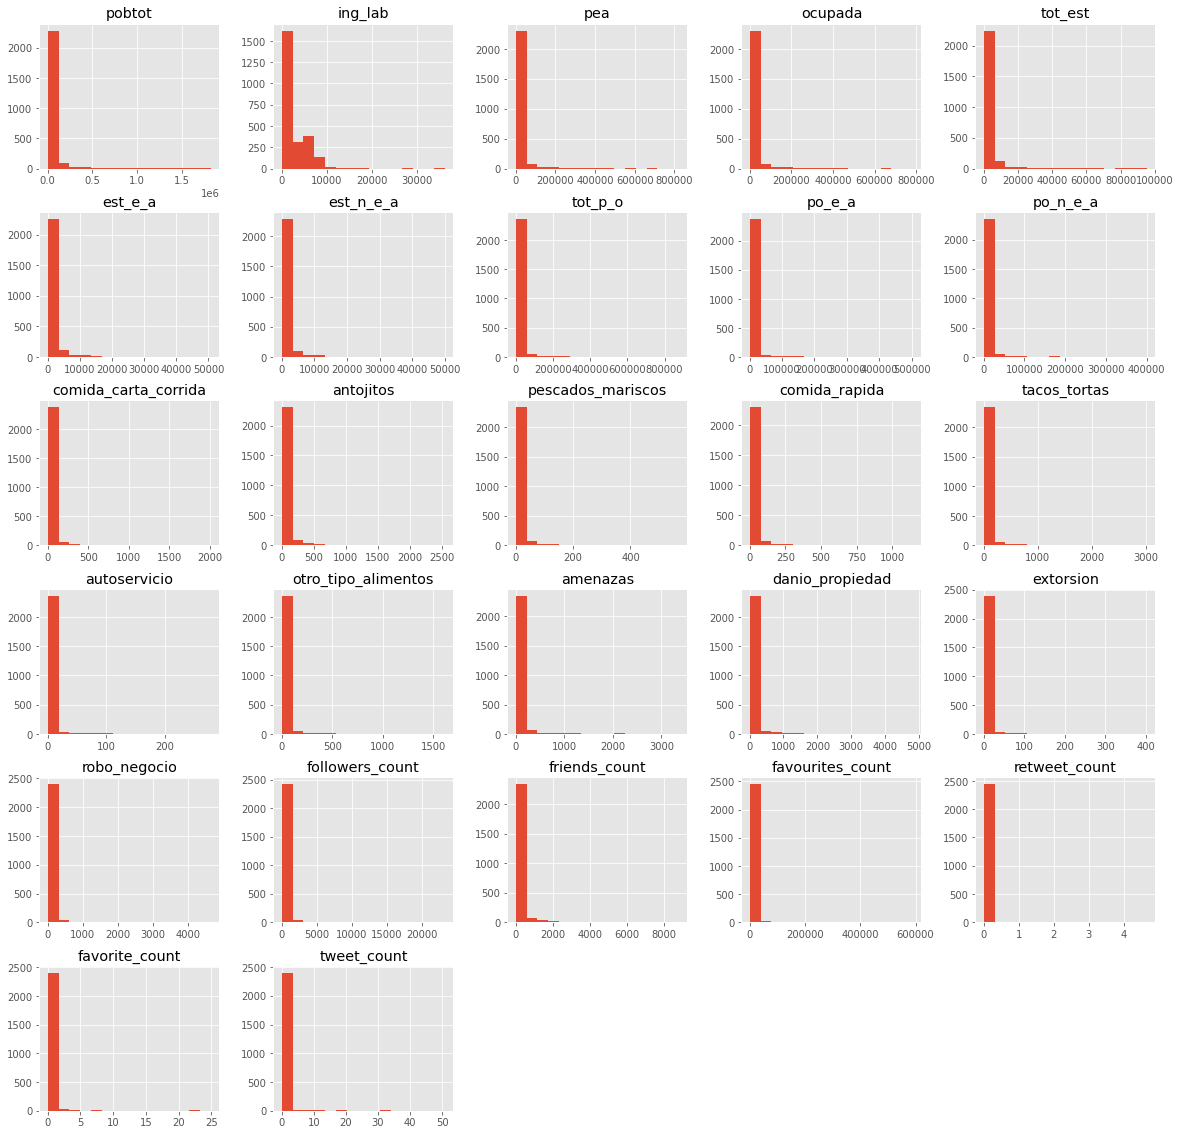

In [12]:
ax = df.hist(bins=15, figsize=(20,20))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

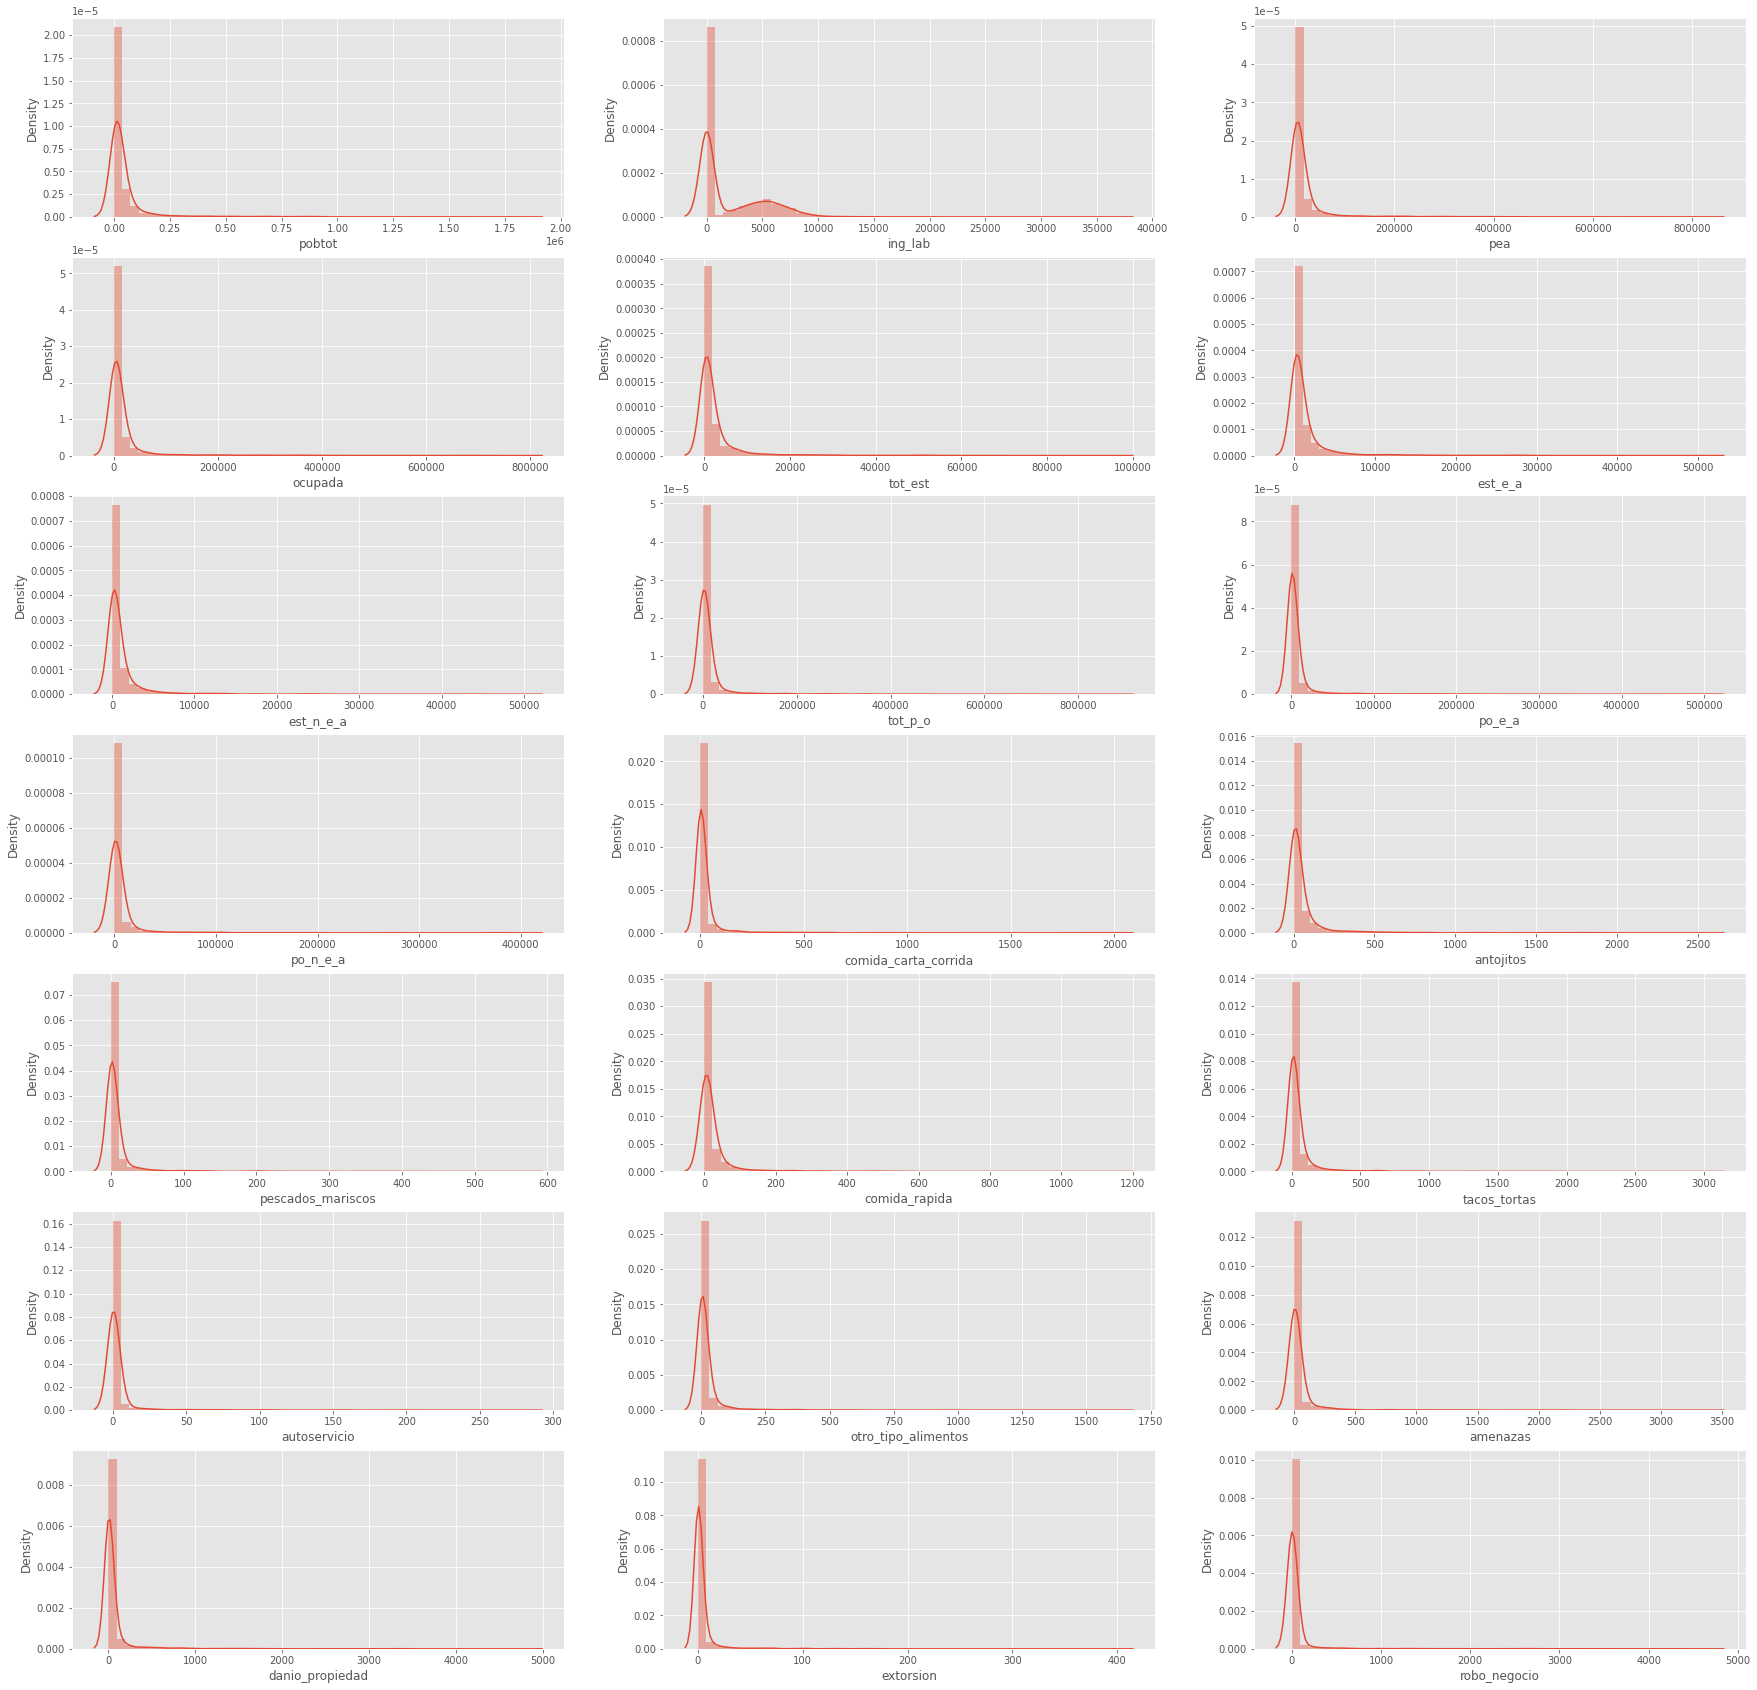

In [13]:
# 'pobtot', 'ing_lab', 'pea', 'ocupada', 'tot_est', 'est_e_a', 'est_n_e_a', 'tot_p_o', 'po_e_a', 'po_n_e_a', 'comida_carta_corrida', 'antojitos', 'pescados_mariscos', 
# 'comida_rapida', 'tacos_tortas', 'autoservicio', 'otro_tipo_alimentos', 'amenazas', 'danio_propiedad','extorsion', 'robo_negocio'
f, axes = plt.subplots(7,3, figsize=(30,30))
sns.distplot(df.pobtot, ax=axes[0,0])
sns.distplot(df.ing_lab, ax=axes[0,1])
sns.distplot(df.pea, ax=axes[0,2])
sns.distplot(df.ocupada, ax=axes[1,0])
sns.distplot(df.tot_est, ax=axes[1,1])
sns.distplot(df.est_e_a, ax=axes[1,2])
sns.distplot(df.est_n_e_a, ax=axes[2,0])
sns.distplot(df.tot_p_o, ax=axes[2,1])
sns.distplot(df.po_e_a, ax=axes[2,2])
sns.distplot(df.po_n_e_a, ax=axes[3,0])
sns.distplot(df.comida_carta_corrida, ax=axes[3,1])
sns.distplot(df.antojitos, ax=axes[3,2])
sns.distplot(df.pescados_mariscos, ax=axes[4,0])
sns.distplot(df.comida_rapida, ax=axes[4,1])
sns.distplot(df.tacos_tortas, ax=axes[4,2])
sns.distplot(df.autoservicio, ax=axes[5,0])
sns.distplot(df.otro_tipo_alimentos, ax=axes[5,1])
sns.distplot(df.amenazas, ax=axes[5,2])
sns.distplot(df.danio_propiedad, ax=axes[6,0])
sns.distplot(df.extorsion, ax=axes[6,1])
sns.distplot(df.robo_negocio, ax=axes[6,2])



## **Algoritmos clasificación no supervisada**
El método de clusterización usado en este proyecto corresponden al rama de ML de aprendizaje no supervisado donde la idea principal es encontrar grupos en los datos que sean similares a otros datos se agrupen en el mismo grupo y los menos similares en otros.

El método de clusterización "K-Means" busca encontrar *k* clusters de modo tal que se minimice la varianza intra-cluster medida, usualmente, como el cuadrado de la distancia euclídea. Para ello el algoritmo empieza encontrando *k centroids* y le asigna a cada sample la etiqueta correspondiente a la del centroid más cercano. Una vez actualizadas las etiquetas de todas las samples, calcula la posición de los k centroids (como el promedio de las features de las samples de cada clúster) y vuelve a asignar etiquetas a cada sample de acuerdo a la distancia al centroid más cercano. Hace estos dos pasos hasta que no haya más cambios de etiqueta.

Debido a esta inicialización aleatoria de los k centroids el output del modelo puede variar al aplicarlo otra vez a la misma data. Por ello se repite este procedimiento n_init=10 veces y el output final es el que mejor resultado tuvo al minimizar la función objetivo (varianza intra-cluster).

### **Normalización de datos**

Para ayudar a nuestro algoritmo K-Means en la interpretación de características con diferentes magnitudes y distribuciones, se normalizaron los datos y  se aplicó PCA (Principal Component Analysis) para reducir dimensiones del espacio de características original, debido a que nos cuestionamos ¿cuáles atributos deberíamos elegir para obtener buenas predicciones o agrupamientos, sin perder información valiosa?  

In [14]:
scaler = StandardScaler()

scaler.fit(df) # Calcula la media y estandar para cada dimensión
X_scaled=scaler.transform(df) # Transforma los datos a su nueva escala

In [15]:
X_scaled

array([[ 5.89844375,  1.83757847,  5.8699753 , ..., -0.09813077,
        -0.1461431 ,  0.1291394 ],
       [-0.02088621,  1.24618869, -0.09058114, ..., -0.09813077,
        -0.1461431 , -0.16634299],
       [ 0.04740449,  1.2205653 ,  0.00942549, ..., -0.09813077,
        -0.1461431 , -0.16634299],
       ...,
       [ 0.68940403,  1.75425597,  0.66896795, ..., -0.09813077,
         5.12563137,  0.42462179],
       [-0.21363785,  1.46589417, -0.21791374, ..., -0.09813077,
        -0.1461431 , -0.16634299],
       [-0.33303969, -0.66651984, -0.30407951, ..., -0.09813077,
        -0.1461431 , -0.16634299]])

### **Busquéda de los componentes principales con algoritmo PCA**

Antes que nada realizamos una descomposición en componentes principales.


In [16]:
pca = PCA(n_components=5)
#pca=PCA(.85)
pca.fit(X_scaled) # Buscar los componentes principales
X_pca=pca.transform(X_scaled) 
#Se revisa la forma del array
print("shape of X_pca", X_pca.shape)

shape of X_pca (2478, 5)


Chequeamos que la matriz X_pca tiene las dimensiones correspondientes (2478 municipios, 5 PCs)

De tal manera que elegir arbitrariamente las dimensiones a considerar dentro del algoritmo no supervisado, no era la opción, así que optamos por calcular la proporción de variación explicada con la cual alcanzamos a explicar 94.07% de la variabilidad total con 5 componentes. 

### Varianza explicada

Varianza explicada del **94%**con los componentes principales calculados en el segmento de código anterior.

In [17]:
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:5]))
# Con 5 componentes tenemos algo mas del 97% de varianza explicada

[0.66381903 0.09424316 0.03805498 0.03550067 0.02982206]
suma: 0.8614399025055266


Se grafica la varianza explicada acumulada en función del número de componentes.

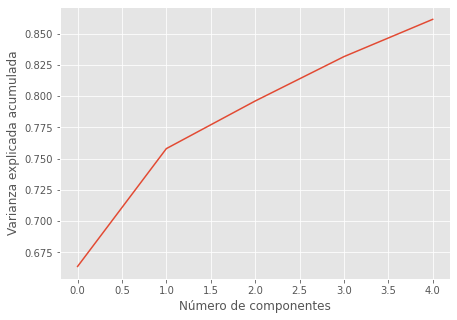

In [18]:
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')

ax.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.show()

Se gráfican los dos primeras componentes principales en función de los nuevos valores obtenidos después de aplicar PCA.

No handles with labels found to put in legend.


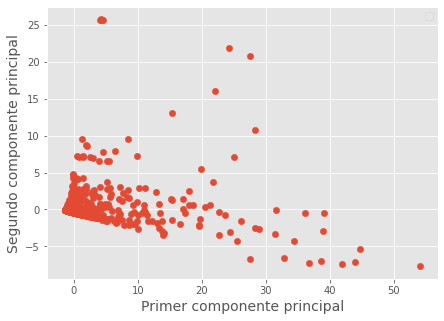

In [19]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')

ax.scatter(Xax,Yax,s=40)

plt.xlabel("Primer componente principal",fontsize=14)
plt.ylabel("Segundo componente principal",fontsize=14)
plt.legend()
plt.show()

Finalmente, se evalúa la correlación entre los componentes principales y los atributos originales. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



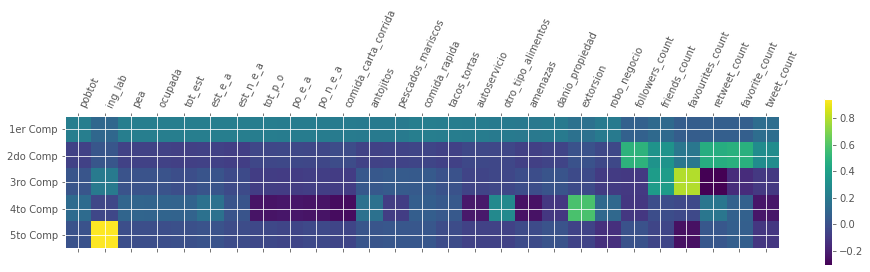

In [20]:
plt.matshow(pca.components_[0:5],cmap='viridis')
plt.yticks([0,1,2,3,4],['1er Comp','2do Comp','3ro Comp','4to Comp','5to Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df.columns)),df.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show();

In [21]:
components = pd.DataFrame(pca.components_, columns = df.columns)
components.shape

(5, 27)

### Algoritmo K-Means



#### Elección del número de clústers K
No hay un consenso en cómo elegir el parámetro *k* para el método KMeans. En algunos casos tenemos una idea de en cuántos grupos deberían estar divididos nuestros datos y simplemente elegimos ese número. Pero en muchos otros casos esta información no la tenemos al momento de hacer el clustering.

En esta parte vamos a ver dos approachs para la elección de k:
1. Inertia
2. Coeficiente de Silhouette
3. Método del codo


#### 1 Inertia
Se busca minimizar el valor de un concepto conocido como inercia, que es la suma de las distancias al cuadrado de cada objeto del Cluster a un punto ‘μ’ conocido como Centroide (punto medio de todos los objetos del clúster).

In [22]:
import sklearn.cluster as cluster

inertia = []
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

100%|██████████| 8/8 [00:01<00:00,  4.26it/s]


#### 2 Silhouette Score

El coeficiente de Silhouette mide qué tan cerca está una muestra a las otras muestras de su cluster y qué tan lejos está con respecto a las muestras del cluster más cercano. Este coeficiente toma valores de [-1,1], -1 sería si los clusters están superpuestos, 0 si hay overlap y 1 que no se tocan.

El coeficiente de Silhouette de cada sample la podemos obtener con la clase 'silhouette_samples' de sklearn.metrics

El puntaje de Silhouette es el promedio de los coeficientes de Silhouette de todas las samples y se computa con la clase 'silhouette_score' de sklearn.metrics. Hay que pasarle a la función los datos y sus etiquetas.

In [23]:
from sklearn.metrics import silhouette_score

silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(X_scaled)
    silhouette[i] = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')

100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Se gráfica los valores de inertia y score del método de la silueta en función del número de clusters.

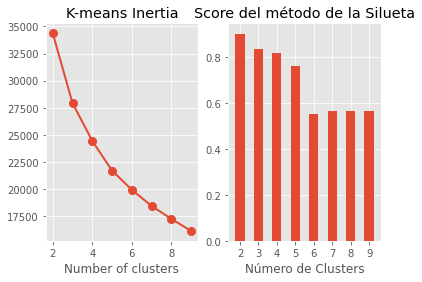

In [24]:
plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8)
plt.xlabel('Number of clusters')
plt.title('K-means Inertia')

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',width=0.5)
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.title('Score del método de la Silueta')
plt.xlabel('Número de Clusters')

plt.show()

#### 3 Método del codo

Se hace un grafico de la función objetivo en función de la elección de k y se elige el k correspondiente al punto donde agregar un cluster más no baja significativamente el valor que queremos minimzar. Esto se puede detectar a ojo o utilizando algún paquete de python como ['kneed'](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf)

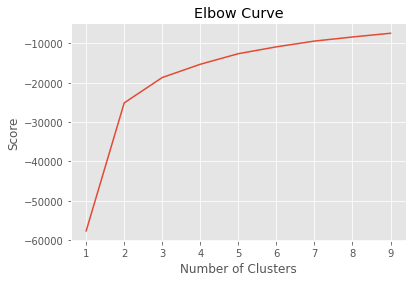

In [25]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_pca).score(X_pca) for i in range(len(kmeans))]
score

plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Despúes de evaluar los resultados de cada metodo de elección del valor *k*, se consideró que 2 era buen número.

In [26]:
# Para el proyecto, se eligio el valor 2 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=2).fit(X_pca)
centroids = kmeans.cluster_centers_
print(centroids)

[[-5.45423778e-01  5.67736969e-04  1.11512479e-02  9.69783360e-03
   1.31263398e-02]
 [ 2.40283966e+01 -2.50113941e-02 -4.91263159e-01 -4.27233651e-01
  -5.78274935e-01]]


Se ejecutó el algoritmo KMeans para 2 clústers, y se graficaron con colores los grupos para ver si se lograban diferenciar entre ellos presentando una buena separación y compactación.  

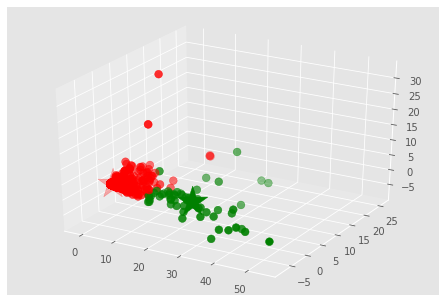

In [27]:
# Se obtienen las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X_pca)
# Se obtienen los centroids
C = kmeans.cluster_centers_
colores=['red','green']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

 Se cuentan los municipios que hay en cada grupo y se grafican posteriormente por cada grupo.

In [28]:
copy =  pd.DataFrame()
copy['imun']=dataframe['imun'].values
copy['ent']=dataframe['ent'].values
copy['nom_ent']=dataframe['nom_ent'].values
copy['mun']=dataframe['mun'].values
copy['nom_mun']=dataframe['nom_mun'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,2423
1,green,55


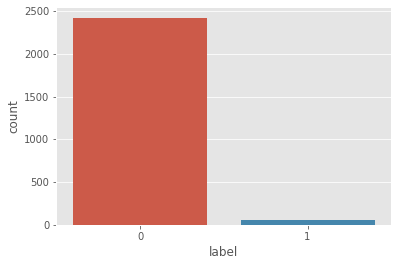

In [29]:
sns.countplot(x=copy.label)

Se agregan a un nuevo dataframe las etiquetas asignadas a cada municipio la información original y los valores transformados de PCA para proceder con la interpretación de los resultados.

In [30]:
column_values = ['C1','C2','C3','C4','C5']  
df_pca = pd.DataFrame(data = X_pca,    
                  columns = column_values) 

In [31]:
df_pca['CVEGEO']=dataframe['CVEGEO'].values
df_pca['imun']=dataframe['imun'].values
df_pca['ent']=dataframe['ent'].values
df_pca['nom_ent']=dataframe['nom_ent'].values
df_pca['mun']=dataframe['mun'].values
df_pca['nom_mun']=dataframe['nom_mun'].values
df_pca['label'] = labels;
df_pca['pobtot']=dataframe['pobtot'].values
df_pca['ing_lab']=dataframe['ing_lab'].values
df_pca['pea']=dataframe['pea'].values
df_pca['ocupada']=dataframe['ocupada'].values
df_pca['tot_est']=dataframe['tot_est'].values
df_pca

,C1,C2,C3,C4,C5,CVEGEO,imun,ent,nom_ent,mun,nom_mun,label,pobtot,ing_lab,pea,ocupada,tot_est
0,27.476891,-6.641687,-0.828347,-0.264757,0.143449,1001,1001,1,Aguascalientes,1,Aguascalientes,1,877190,7676.46,382550,367528,46426
1,-0.476477,-0.187313,0.203053,-0.130591,1.261317,1002,1002,1,Aguascalientes,2,Asientos,0,46464,5863.52,13914,13108,989
2,0.128215,-0.330671,0.177362,0.010332,1.222954,1003,1003,1,Aguascalientes,3,Calvillo,0,56048,5784.97,20099,19352,3280
3,-0.809705,-0.089071,0.206406,-0.011781,1.336445,1004,1004,1,Aguascalientes,4,Cosío,0,15577,6096.05,4869,4627,1000
4,2.375463,-0.848227,0.046458,-0.301931,1.210199,1005,1005,1,Aguascalientes,5,Jesús María,0,120405,6262.18,51020,49795,6377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,-1.116120,-0.090512,-0.048762,0.043135,0.063738,32054,32054,32,Zacatecas,54,Villa Hidalgo,0,19155,1877.31,4538,4324,423
2474,-0.411749,-0.295972,-0.183744,0.219183,-0.529515,32055,32055,32,Zacatecas,55,Villanueva,0,30240,0.00,9018,8176,3532
2475,5.708622,2.963125,0.753328,2.049507,1.275051,32056,32056,32,Zacatecas,56,Zacatecas,0,146147,7421.03,60889,58330,9716
2476,-0.774185,-0.073464,0.245704,0.200833,1.468149,32057,32057,32,Zacatecas,57,Trancoso,0,19413,6537.04,6039,5703,665


### Interpretación de los grupos resultantes

**Grupo 0**: el número de municipios contenidos corresponde a 2,357, los cuales presentan un bajo número del total de población, por lo mismo tienen baja población económicamente activa y bajo número de empleados. Esto conlleva que el total de establecimientos también sea bajo. Lo único favorable de este grupo es que hay ciertas regiones con altos salarios, pero este grupo dado sus características se convierte en la opción menos deseable para iniciar un negocio. 

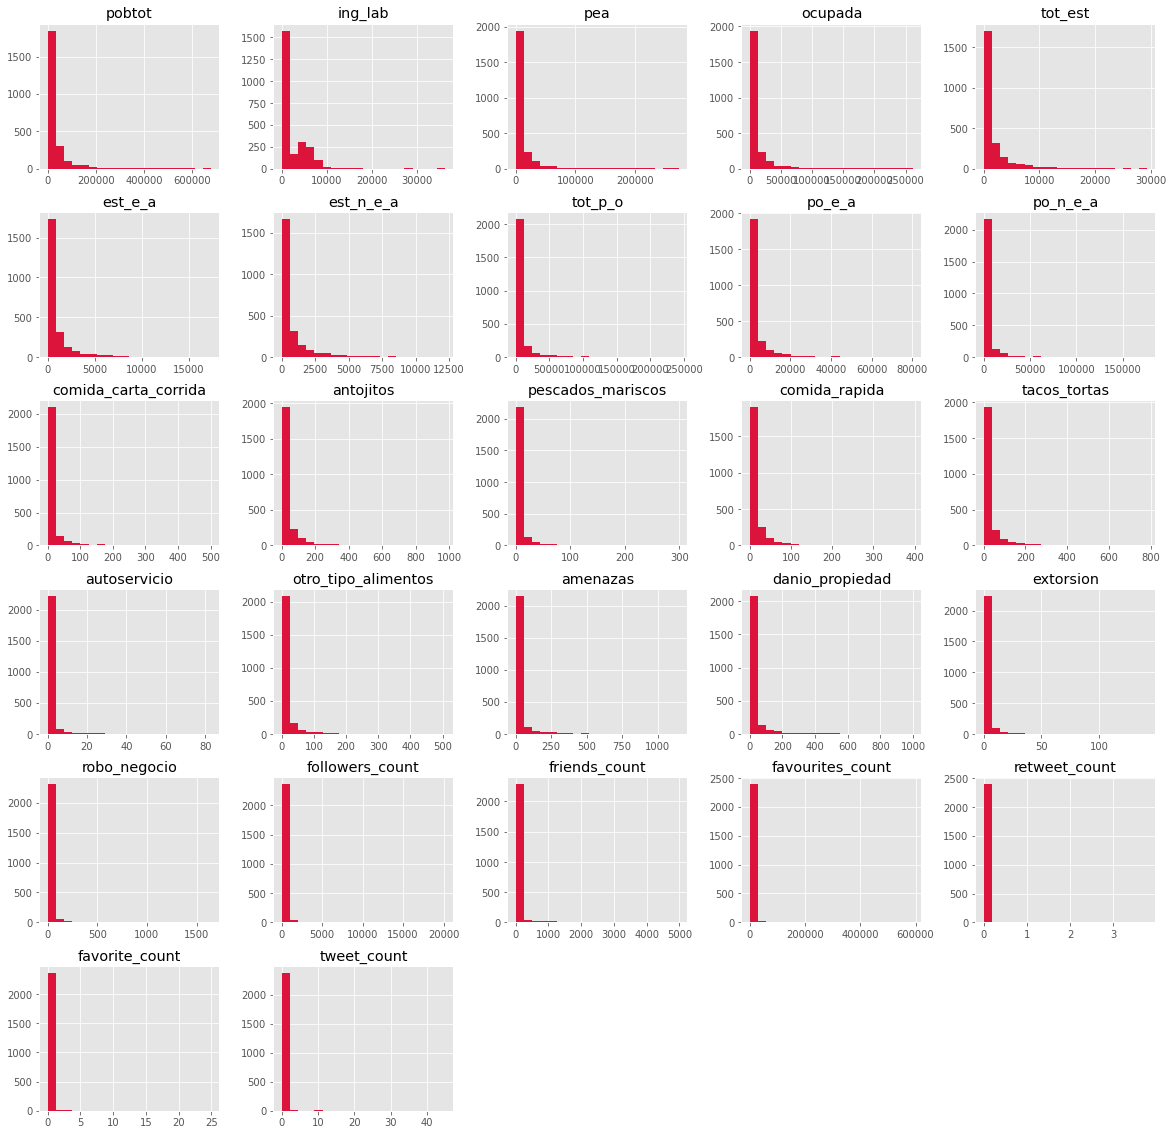

In [32]:
dataframe2 = df.copy()
dataframe2['Cluster'] = labels

aux = dataframe2.columns.tolist()
aux = aux[0:len(aux)-1]

# Grupo 0 

data_grupo0 = dataframe2[dataframe2['Cluster'] == 0]

data_grupo0[aux].hist(bins=20, color='#DC143C', figsize = (20,20));

In [33]:
round(data_grupo0[aux].describe(), 2)

,pobtot,ing_lab,pea,ocupada,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,amenazas,danio_propiedad,extorsion,robo_negocio,followers_count,friends_count,favourites_count,retweet_count,favorite_count,tweet_count
count,2423.0,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00,2423.00
mean,32199.6,1902.70,11789.11,11300.85,1749.47,958.30,791.17,7694.89,3757.41,3937.48,14.79,37.65,6.09,17.96,34.67,1.73,15.20,29.33,33.48,2.53,17.33,99.96,60.86,1440.27,0.01,0.19,0.29
std,61033.5,2927.82,25234.03,24227.98,3048.79,1668.47,1406.41,18315.92,8360.79,10567.54,36.19,81.29,17.51,37.82,74.18,5.99,38.83,86.66,90.08,9.71,79.43,917.85,299.89,14654.63,0.20,1.50,2.33
min,0.0,0.00,0.00,0.00,7.00,5.00,2.00,17.00,13.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4104.0,0.00,1170.50,1123.00,164.00,93.00,63.00,486.50,263.00,188.00,1.00,2.00,0.00,1.00,2.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,12783.0,0.00,3955.00,3777.00,584.00,330.00,247.00,1779.00,977.00,748.00,3.00,9.00,1.00,5.00,9.00,0.00,4.00,4.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,31487.5,4129.12,10287.00,9835.00,1878.50,1026.50,838.00,6016.50,3169.50,2889.00,12.00,34.00,4.00,17.00,30.00,1.00,12.00,17.00,22.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00
max,679811.0,36323.24,274254.00,262343.00,29407.00,17399.00,12212.00,243203.00,80543.00,176286.00,502.00,977.00,300.00,397.00,783.00,83.00,508.00,1153.00,1001.00,142.00,1648.00,20210.59,4998.00,591717.00,3.78,25.00,45.00


**Grupo 1**: está conformado por 82 municipios con población total, ingreso laboral, población económicamente activa, número de ocupados y total de establecimientos en rangos promedios. Es probable que se exijan alimentos baratos o con precios promedio, y su número de establecimientos también indica que existe mayor competencia culinaria. 

**Grupo 2**: están agrupados 24 municipios con altos valores en todos sus indicadores sociodemográficos, excluyendo únicamente el ingreso laboral debido a el salario de estas regiones son promedio. Aunque por la gran afluencia de la zona y el número de personas económicamente activas se puede determinar que estos municipios representan las mejores opciones para iniciar un negocio, lo único en contra es la cantidad de establecimientos que representan una competencia.

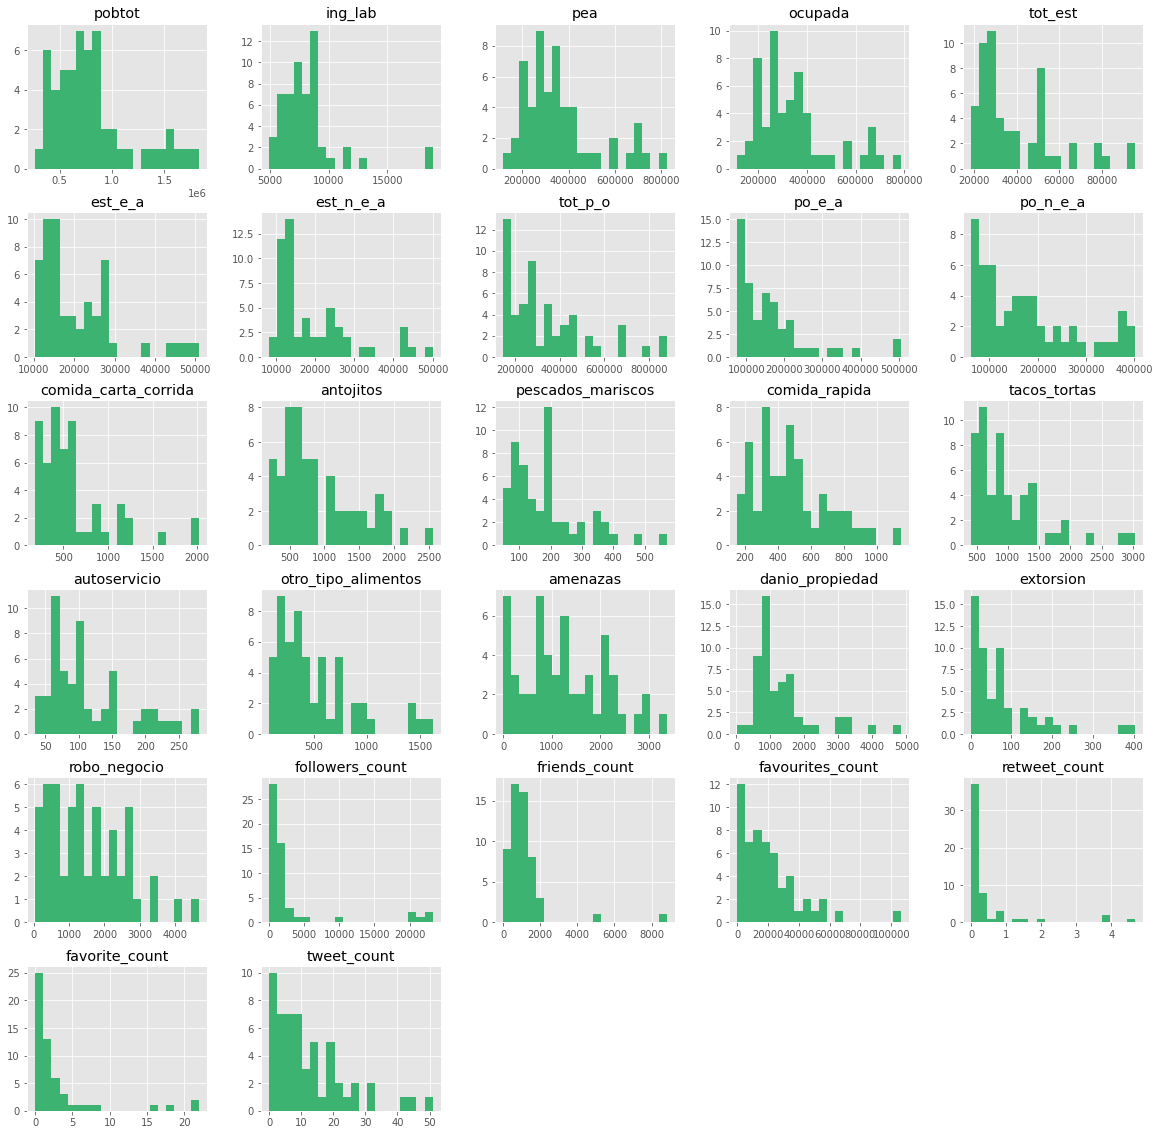

In [34]:
# Grupo 1

data_grupo1 = dataframe2[dataframe2['Cluster'] == 1]

data_grupo1[aux].hist(bins=20, color='#3CB371', figsize = (20,20));

In [35]:
round(data_grupo1[aux].describe(), 2)

,pobtot,ing_lab,pea,ocupada,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,amenazas,danio_propiedad,extorsion,robo_negocio,followers_count,friends_count,favourites_count,retweet_count,favorite_count,tweet_count
count,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00
mean,806939.47,8235.54,359923.71,345914.64,39853.07,20570.45,19282.62,339918.07,164420.76,175497.33,611.00,916.29,188.62,482.95,1010.60,115.64,502.25,1223.64,1348.38,75.75,1510.71,3221.99,1159.20,20562.63,0.45,2.98,12.49
std,372782.11,2613.50,162046.84,155319.85,19233.59,9764.62,10153.53,187673.77,96751.95,99110.11,414.61,549.81,110.84,223.63,560.24,61.70,371.97,860.55,924.75,86.36,1074.03,6126.96,1274.20,19277.00,0.97,4.98,11.54
min,264251.00,4941.37,116220.00,112276.00,18496.00,10290.00,8206.00,147928.00,76069.00,62121.00,182.00,207.00,49.00,153.00,414.00,35.00,82.00,0.00,33.00,1.00,44.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,532553.00,6708.08,247366.50,238469.50,25793.00,13455.00,12254.50,190545.50,94465.00,94605.50,341.50,522.00,104.00,316.00,632.50,68.50,230.50,670.50,793.00,19.50,542.50,366.10,769.05,7680.07,0.00,0.68,4.00
50%,700734.00,7741.85,319578.00,307257.00,30721.00,17474.00,14449.00,276451.00,145082.00,157924.00,498.00,708.00,176.00,472.00,857.00,99.00,381.00,1069.00,1020.00,54.00,1294.00,1101.71,918.44,16102.11,0.08,1.33,9.00
75%,888318.00,8840.63,403511.50,388608.50,50461.00,25914.50,23674.50,426846.50,189776.50,230814.00,677.00,1227.50,222.50,593.00,1257.00,151.50,678.50,1845.50,1577.50,94.00,2275.50,1867.02,1250.25,27702.76,0.36,2.72,18.00
max,1827868.00,18849.13,825520.00,786218.00,95568.00,50880.00,50039.00,879056.00,505363.00,401413.00,2018.00,2552.00,570.00,1147.00,3030.00,280.00,1619.00,3366.00,4835.00,403.00,4664.00,23305.25,8820.25,106135.00,4.67,21.94,51.00


### Visualización de datos avanzada 

Con el fin de explorar y entender con más detalle nuestros datos, se presentaron las etiquetas resultantes del algoritmo no supervisado de los municipios en un mapa cloroplético.

Se consultaron los polígonos geográficos del Marco Geoestadistico publicado por el INEGI. Se integraron ambos dataframes con el atributo CVEGEO, en este campo se concatenan dos digitos que representan a la entidad y tres digitos que represetan al municipio. Con este atributo, se logró integrar el dataset resultante con la información geográfica.

In [37]:
mun_geo = geopandas.read_file("https://github.com/Walt9819/factores-impacto-desempleo-mexico/blob/main/AD_Python/data/mun2019gw.zip?raw=true")

In [38]:
# Se transforma a la clave geográfica de int a str, para hacer merge
df_pca['CVEGEO'] = df_pca['CVEGEO'].astype(str)
df_pca['CVEGEO'] = df_pca['CVEGEO'].str.zfill(5)

In [39]:
mun_geo

,CVEGEO,CVE_ENT,CVE_MUN,NOM_ENT,AREA,PERIMETER,COV_,COV_ID,NOM_MUN,geometry
0,01001,01,001,Aguascalientes,116635.924760,256.631026,0,1,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0..."
1,01002,01,002,Aguascalientes,54337.426596,192.096428,1,2,Asientos,"POLYGON ((-102.05189 22.29144, -102.05121 22.2..."
2,01003,01,003,Aguascalientes,92335.783227,171.636168,2,3,Calvillo,"POLYGON ((-102.68569 22.09963, -102.69087 22.0..."
3,01004,01,004,Aguascalientes,12838.354453,73.352682,3,4,Cosío,"POLYGON ((-102.28787 22.41649, -102.28753 22.4..."
4,01005,01,005,Aguascalientes,49989.509147,163.500810,4,5,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0..."
...,...,...,...,...,...,...,...,...,...,...
2460,32054,32,054,Zacatecas,37142.598661,119.022381,2460,2461,Villa Hidalgo,"POLYGON ((-101.69490 22.51777, -101.69472 22.5..."
2461,32055,32,055,Zacatecas,215650.560215,351.736263,2461,2462,Villanueva,"POLYGON ((-102.78252 22.67373, -102.78221 22.6..."
2462,32056,32,056,Zacatecas,43682.101046,139.065402,2462,2463,Zacatecas,"POLYGON ((-102.76690 22.84147, -102.76619 22.8..."
2463,32057,32,057,Zacatecas,21844.700671,66.167468,2463,2464,Trancoso,"POLYGON ((-102.22547 22.80920, -102.22946 22.7..."


Merge entre el dataset etiquetado y el información geoespacial.

In [40]:
mun_pca_merge = pd.merge(mun_geo, df_pca, left_on = ['CVEGEO'], right_on = ['CVEGEO'], how = 'left')

In [41]:
mun_pca_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2480 entries, 0 to 2479
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CVEGEO     2480 non-null   object  
 1   CVE_ENT    2480 non-null   object  
 2   CVE_MUN    2480 non-null   object  
 3   NOM_ENT    2480 non-null   object  
 4   AREA       2480 non-null   float64 
 5   PERIMETER  2480 non-null   float64 
 6   COV_       2480 non-null   int64   
 7   COV_ID     2480 non-null   int64   
 8   NOM_MUN    2480 non-null   object  
 9   geometry   2480 non-null   geometry
 10  C1         2478 non-null   float64 
 11  C2         2478 non-null   float64 
 12  C3         2478 non-null   float64 
 13  C4         2478 non-null   float64 
 14  C5         2478 non-null   float64 
 15  imun       2478 non-null   float64 
 16  ent        2478 non-null   float64 
 17  nom_ent    2478 non-null   object  
 18  mun        2478 non-null   float64 
 19  nom_mun    2478 non

Visualización del mapa estatico con el módulo `matplotlib`, amarillo grupo 0 y morado grupo 1.

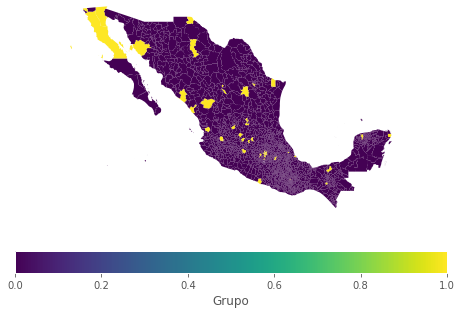

In [42]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

mun_pca_merge.plot(ax=ax, column='label', legend=True, legend_kwds={'label': "Grupo", 
                                                                    'orientation': "horizontal"})
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

Visualización dinámica del mapa con la misma información, se usó el modulo de python `bokeh`.

In [43]:
# Grupo 0 Rojo, Grupo 1 Verde
mun_pca_merge.plot_bokeh(
    figsize=(900, 600),
    simplify_shapes=500,
    category="label",
    show_colorbar=False,
    colormap=['#DC143C', '#3CB371'],
    hovertool_columns=["nom_ent",'nom_mun', "label"],
    tile_provider="STAMEN_TERRAIN_RETINA")

Figure(id='1002', ...)

## Validación del modelo de datos

Para validar nuestro modelo dividimos el conjunto de datos resultantes del K-Means en un set de entrenamiento y otro pruebas, y aplicamos un modelo de regresión logística y otra de random forest para hacer las predicciones. 

In [44]:
y = df_pca['label']
X = df_pca.drop(['label','imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO','pobtot', 'ing_lab', 'pea', 'ocupada', 'tot_est'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [45]:
df_pca.columns

Index(['C1', 'C2', 'C3', 'C4', 'C5', 'CVEGEO', 'imun', 'ent', 'nom_ent', 'mun',
       'nom_mun', 'label', 'pobtot', 'ing_lab', 'pea', 'ocupada', 'tot_est'],
      dtype='object')

In [46]:
y = df_pca['label']
X = df_pca.drop(['label','imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO','pobtot', 'ing_lab', 'pea', 'ocupada', 'tot_est'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [47]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

Se ejecuta modelo con `LogistiRegression` para poder analizar si se puede poner un nuevo restaurante o no.

In [48]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

La matriz de confusión  muestra cuántos resultados equivocados tuvo cada clase. Esta se calcula para amobos algoritmos.

### Regresión logística

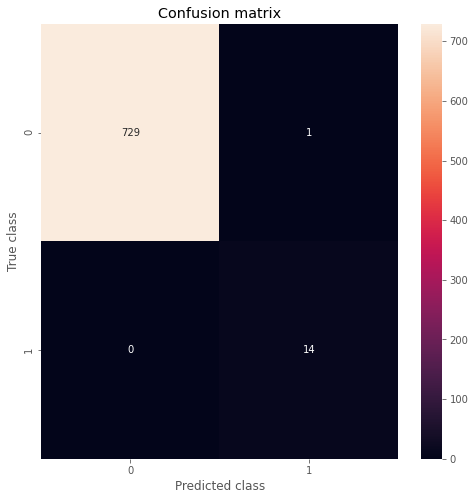

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       730
           1       0.93      1.00      0.97        14

    accuracy                           1.00       744
   macro avg       0.97      1.00      0.98       744
weighted avg       1.00      1.00      1.00       744



In [49]:
LABELS = [0,1]
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Random Forest

Se valida con el modelo `RandomForestClassifier`.

In [50]:
from sklearn.ensemble import RandomForestClassifier
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=50, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


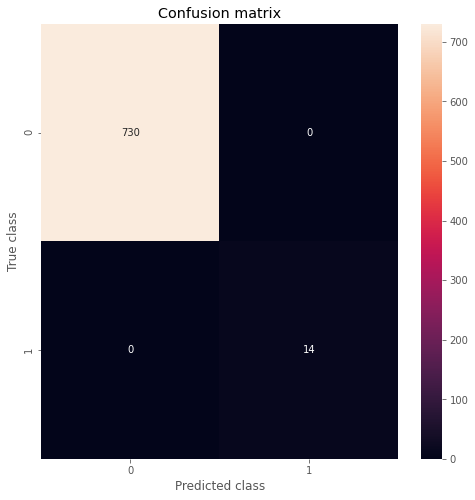

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       730
           1       1.00      1.00      1.00        14

    accuracy                           1.00       744
   macro avg       1.00      1.00      1.00       744
weighted avg       1.00      1.00      1.00       744



In [51]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

La valoración que nos conviene analizar es la de F1-score que toma en cuenta la precisión y recall. El promedio de F1 para ambos modelos fluctua entre 98% - 100%.

Si se comparan los resultados de ambos algoritmos, vemos que Random Forest dió mejores resultados, menos falsos positivos y mejores métricas generales a pesar de tener un conjunto de datos de entrada muy desigual.

### Red neuronal

Las redes neuronales artificiales (en inglés, ANN, Artificial Neural Networks) se inspiran en el sistema nervioso y el comportamiento biológico, creando un sistema de interconexión en capas de neuronas artificiales que colaboran para procesar datos de entrada y generar salidas. 

Con este modelo se validó la predicción de las etiquetas 0 - 1 con el objetivo de definir si se apertura o no un nuevo restaurante en la zona.

In [52]:
from sklearn.preprocessing import Normalizer

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import Normalizer
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
%matplotlib inline
#plt.style.use('fivethirtyeight')

Se preparan los datos en conjunto de entrenamiento y de prueba. Se normalizan los datos.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
nl = Normalizer()
nl.fit(X_train)
X_train = nl.transform(X_train)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)
X_dev = nl.transform(X_dev)
X_test = nl.transform(X_test)

La arquitectura de la red completa tres capas ocultas y una capa de salida con una activación sigmoide.

In [54]:

def nn():
    inputs = Input(name='inputs', shape=[X_train.shape[1],])
    layer = Dense(128, name='FC1')(inputs)
    layer = BatchNormalization(name='BC1')(layer)
    layer = Activation('relu', name='Activation1')(layer)
    layer = Dropout(0.3, name='Dropout1')(layer)
    layer = Dense(128, name='FC2')(layer)
    layer = BatchNormalization(name='BC2')(layer)
    layer = Activation('relu', name='Activation2')(layer)
    layer = Dropout(0.3, name='Dropout2')(layer)
    layer = Dense(128, name='FC3')(layer)
    layer = BatchNormalization(name='BC3')(layer)
    layer = Dropout(0.3, name='Dropout3')(layer)
    layer = Dense(1, name='OutLayer')(layer)
    layer = Activation('sigmoid', name='sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [55]:
model = nn()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 5)]               0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               768       
_________________________________________________________________
BC1 (BatchNormalization)     (None, 128)               512       
_________________________________________________________________
Activation1 (Activation)     (None, 128)               0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
BC2 (BatchNormalization)     (None, 128)               512   

Se compila y ajusta el modelo

In [56]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Se definen los callbacks.

In [57]:
reduce_lr = ReduceLROnPlateau()
early_stopping = EarlyStopping(patience=20, min_delta=0.0001)

Se evalua la precisión del modelo.

In [58]:
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_dev, y_dev), callbacks=[reduce_lr, early_stopping], verbose=0)

In [59]:
x_lst = [X_train, X_dev, X_test]
y_lst = [y_train, y_dev, y_test]
for i,(x,y) in enumerate(zip(x_lst, y_lst)):
    y_pred = model.predict(x)
    y_pred = np.around(y_pred)
    y_pred = np.asarray(y_pred)
    if i == 0:
        print('Training set:')
        print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y, y_pred), 
                                                                  classification_report(y, y_pred)))
    elif i == 1:
        print('Dev set:')
        print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y, y_pred), 
                                                                  classification_report(y, y_pred)))
    else:
        print('Test set:')
        print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y, y_pred), 
                                                                  classification_report(y, y_pred)))

Training set:
	Accuracy:0.993
	Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1701
           1       0.80      0.85      0.82        33

    accuracy                           0.99      1734
   macro avg       0.90      0.92      0.91      1734
weighted avg       0.99      0.99      0.99      1734

Dev set:
	Accuracy:0.989
	Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       359
           1       0.91      0.77      0.83        13

    accuracy                           0.99       372
   macro avg       0.95      0.88      0.91       372
weighted avg       0.99      0.99      0.99       372

Test set:
	Accuracy:0.997
	Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       363
           1       0.90      1.00      0.95         9

    accuracy                    

Los valores de avg score para el conjunto de entrada se encuentran entre 91% y 97%, con lo cual se puede definir que es un buen módelo.